목록

1. Dataset(torch.utils.data.Dataset)

2. Transform(albumentations)

3. DataLoader(torch.utils.data.DataLoader)

4. Model(timm efficientnet)

5. Train

6. Result

레이블 : pandas

이미지 : PIL

transform : albumentations

모델 : timm

데이터셋/로더 : torch.utils.data

In [38]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from glob import glob
from PIL import Image
from albumentations import *
from albumentations.pytorch import ToTensorV2
from facenet_pytorch import MTCNN

import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(0)

class path:
    train = '/opt/ml/input/data/train'
    train_img = train + '/images'
    
class FaceDataset(Dataset):
    class label:
        age2label = lambda x : 0 if x < 30 else 1 if x < 60 else 2
        gender = {'male' : 0, 'female' : 1}
        mask2label = lambda x : 0 if x.startswith('mask') else 1 if x.startswith('incorrect') else 2

    def __init__(self, img_path, transform, range, crop_margin=60):
        self.img = []
        self.age_label = []
        self.gender_label = []
        self.mask_label = []
        self.transform = transform
        self.mtcnn = MTCNN()
        self.crop_margin = crop_margin
        groups = glob(img_path + '/*')

        groups = groups[range[0]:range[1]]

        for group in groups:
            info_list = os.path.basename(group).split('_')
            gender = self.label.gender[info_list[1]]
            age = self.label.age2label(int(info_list[3]))
            
            imgs = glob(group + '/*')
            for img in imgs:
                mask = self.label.mask2label(os.path.basename(img))
                
                self.img.append(img)
                self.age_label.append(age)
                self.gender_label.append(gender)
                self.mask_label.append(mask)
    
    def __getitem__(self, index):
        img = Image.open(self.img[index])
        raw_image_size = img.size
        boxes, probs = self.mtcnn.detect(img)
        if not boxes is None:
            box = [
                int(max(boxes[0, 0] - self.crop_margin / 2, 0)),
                int(max(boxes[0, 1] - self.crop_margin / 2, 0)),
                int(min(boxes[0, 2] + self.crop_margin / 2, raw_image_size[0])),
                int(min(boxes[0, 3] + self.crop_margin / 2, raw_image_size[1])),
            ]
            img = img.crop(box)
        else:
            trans = CenterCrop(224, 224, p=1)
            img = trans(image=np.array(img))['image']
        img = self.transform(image=np.array(img))['image']
        label = {
            'mask':self.mask_label[index],
            'gender':self.gender_label[index],
            'age':self.age_label[index]
        }
        return img, label

    def __len__(self):
        return len(self.img)

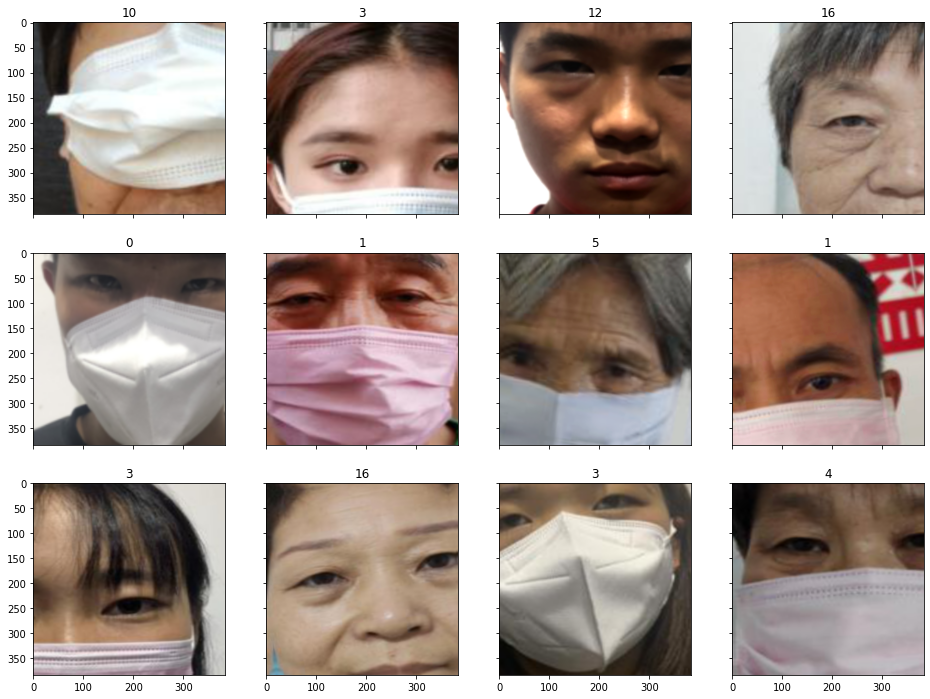

In [33]:
transform = Compose([
    Resize(384, 384, p=1.0),
    RandomCrop(224, 224, p=1.0),
    Resize(384, 384, p=1.0),
    HorizontalFlip(p=.5),
    Rotate(10),
    ColorJitter()
])

all_dataset = FaceDataset(path.train_img, transform, range=(0, 2700))

all_loader = DataLoader(
    all_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=True
)

imgs, labels = next(iter(all_loader))
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(16,12))
for i in range(3):
    for j in range(4):
        axes[i][j].imshow(imgs[i * 4 + j])
        axes[i][j].set_title(f'{labels[i * 4 + j]}')

In [47]:
import timm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(0)

transform_ageNgender = Compose([
    Resize(384, 384, p=1.0),
    RandomCrop(224, 224, p=1.0),
    Resize(384, 384, p=1.0),
    HorizontalFlip(p=.5),
    Rotate(10)
])
transform_mask = Compose([
    Resize(384, 384, p=1.0),
    ColorJitter(),
    HorizontalFlip(p=.5),
    Rotate(10)
])

dataset_ageNgender = []
dataloader_ageNgender = []
dataset_mask = []
dataloader_mask = []
num_data = 2700
num_fold = 5
for i in range(num_fold):
    dataset_ageNgender.append(FaceDataset(path.train_img, transform_ageNgender, range=(num_data * i // num_fold, num_data * (i + 1) // num_fold)))
    dataloader_ageNgender.append(DataLoader(
        dataset_ageNgender[i],
        batch_size=12,
        num_workers=4,
        shuffle=True
    ))
    dataset_mask.append(FaceDataset(path.train_img, transform_mask, range=(num_data * i // num_fold, num_data * (i + 1) // num_fold)))
    dataloader_mask.append(DataLoader(
        dataset_mask[i],
        batch_size=12,
        num_workers=4,
        shuffle=True
    ))

model_age = timm.create_model('efficientnet_b0', pretrained=True, num_classes=3)
model_gender = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)
model_mask = timm.create_model('efficientnet_b0', pretrained=True, num_classes=3)

lr = 0.0005
optimizer_age = torch.optim.Adam(filter(lambda p : p.requires_grad, model_age.parameters()), lr=lr)
optimizer_gender = torch.optim.Adam(filter(lambda p : p.requires_grad, model_gender.parameters()), lr=lr)
optimizer_mask = torch.optim.Adam(filter(lambda p : p.requires_grad, model_mask.parameters()), lr=lr)
scheduler_age = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_age, factor=0.1, patience=10)
scheduler_gender = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_gender, factor=0.1, patience=10)
scheduler_mask = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_mask, factor=0.1, patience=10)
criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /opt/ml/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [50]:

def model_training(model, optimizer, scheduler, criterion, train_loader, subject):
    train_log_interval = 90
    batch_size = 12
    num_epochs = 20

    counter = 0
    best_val_acc = 0
    best_val_loss = np.inf
    patience = 10

    device = torch.device('cuda')
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        loss_value = 0
        matches = 0
        
        train_indices = [i for i in range(num_fold) if i != epoch % num_fold]
        valid_index = epoch % 5
        for train_index in train_indices:
            print(train_index + 1, 'th fold training')
            for i, data in enumerate(train_loader[train_index]):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs.permute(0, 3, 1, 2).float())
                preds = torch.argmax(outputs, dim=-1)

                loss = criterion(outputs, labels[subject])
                loss.backward()
                optimizer.step()

                loss_value += loss.item()
                matches += (preds == labels).sum().item()
                if (i + 1) % train_log_interval == 0:
                    train_loss = loss_value / train_log_interval
                    train_acc = matches / batch_size / train_log_interval
                    print(subject, 'epoch:', epoch + 1, 'batch:', i + 1, 'train loss:', train_loss, 'train accuracy', train_acc)

        model.eval()
        val_loss_items = []
        val_acc_items = []
        with torch.no_grad():
            print("Calculating validation results")
            for val_batch in train_loader[valid_index]:
                inputs, labels = val_batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs.permute(0, 3, 1, 2).float())
                preds = torch.argmax(outputs, dim=-1)

                loss_item = criterion(outputs, labels[subject]).item()
                acc_item = (labels == preds).sum().item()
                val_loss_items.append(loss_item)
                val_acc_items.append(acc_item)

            val_loss = np.sum(val_loss_items) / len(train_loader[valid_index])
            val_acc = np.sum(val_acc_items) / len(train_dataset[valid_index])

            if val_loss < best_val_loss:
                best_val_loss = val_loss
            
            if val_acc > best_val_acc:
                print("New best model for val accuracy! saving the model")
                save_path = f'results/{subject}'
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                torch.save(model.state_dict(), save_path + f'/{epoch:03}_accuracy_{val_acc:4.2%}.ckpt')
                best_val_acc = val_acc
                counter = 0
            else:
                counter += 1

            if counter > patience:
                print('Early stopping')
                break

            print('val_acc:', val_acc, 'loss:', val_loss, 'best acc:', best_val_acc, 'best loss:', best_val_loss)
            
            scheduler.step(val_loss)

    print('Finishing Training')

In [51]:
model_training(model_age, optimizer_age, scheduler_age, criterion, dataloader_ageNgender, 'age')
model_training(model_age, optimizer_age, scheduler_age, criterion, dataloader_ageNgender, 'gender')
model_training(model_age, optimizer_age, scheduler_age, criterion, dataloader_mask, 'mask')

RuntimeError: CUDA error: device-side assert triggered

In [21]:
os.makedirs(f'results/{name}')
torch.save(model.state_dict(), f'results/{name}/{epoch:03}_accuracy_{val_acc:4.2%}.ckpt')

In [26]:
if not os.path.exists(f'results/{name}'):
    os.makedirs(f'results/{name}')

Filesystem      Size  Used Avail Use% Mounted on
overlay          48G   33G   12G  74% /
tmpfs            64M     0   64M   0% /dev
tmpfs            30G     0   30G   0% /sys/fs/cgroup
shm             1.0G     0  1.0G   0% /dev/shm
/dev/xvda1       48G   33G   12G  74% /etc/hosts
tmpfs            30G   12K   30G   1% /proc/driver/nvidia
udev             30G     0   30G   0% /dev/nvidia1
tmpfs            30G     0   30G   0% /proc/acpi
tmpfs            30G     0   30G   0% /proc/scsi
tmpfs            30G     0   30G   0% /sys/firmware
